In [1]:
library(ggplot2)
library(plyr)
library(dplyr)
library(data.table)
library(readxl)
library(tidyr)
library(tidyverse)
library(grid)
library(gridExtra)
library(survival)
library(survminer)
library(ggplot2)
library(ggsignif) 
library(ggpubr) 
library(reshape2)
library(ggsci) 
library(patchwork)
library(cowplot)

options(repr.matrix.max.rows=600, repr.matrix.max.cols=200) 
options(repr.plot.width = 6, repr.plot.height = 6)


载入程辑包：'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



载入程辑包：'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v readr     2.1.4
v lubridate 1.9.2     v stringr   1.5.0
v purrr     1.0.1     v tibble    3.2.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::arrange()      masks plyr::arrange()
x data.table::between() masks dplyr::between()
x purrr::compact()      masks plyr::compact()
x dplyr::count()        masks plyr::count()
x dplyr::desc()         masks plyr::desc()
x dplyr::failwith()     masks plyr::failwith()
x dplyr::filte

## define the diversity calculate function

In [2]:
#diversity calc function: https://www.jianshu.com/p/c5ff5446fd79

Shannon_index <- function(list_p){
  sum=0
  for (p in list_p){
    sum <- p*log(p) + sum
  }
  H <- -sum
  return(H)
}
clonality <- function(diversity,richness){
  E<- diversity/log(richness)##log equals loge
  C <- 1-E
  return(C)
}

list_p <- c(0.5,0.5)
print('richness is:')
length(list_p)
print('Shannon index is:')
Shannon_index(list_p)
print('Clonality index is:')
clonality(Shannon_index(list_p),length(list_p))

[1] "richness is:"


[1] 2

[1] "Shannon index is:"


[1] 0.6931472

[1] "Clonality index is:"


[1] 0

In [3]:
ROIE <- function(crosstab){
  ## Calculate the Ro/e value from the given crosstab
  ##
  ## Args:
  #' @crosstab: the contingency table of given distribution
  ##
  ## Return:
  ## The Ro/e matrix 
  rowsum.matrix <- matrix(0, nrow = nrow(crosstab), ncol = ncol(crosstab))
  rowsum.matrix[,1] <- rowSums(crosstab)
  colsum.matrix <- matrix(0, nrow = ncol(crosstab), ncol = ncol(crosstab))
  colsum.matrix[1,] <- colSums(crosstab)
  allsum <- sum(crosstab)
  roie <- divMatrix(crosstab, rowsum.matrix %*% colsum.matrix / allsum)
  row.names(roie) <- row.names(crosstab)
  colnames(roie) <- colnames(crosstab)
  return(roie)
}

divMatrix <- function(m1, m2){
  ## Divide each element in turn in two same dimension matrixes
  ##
  ## Args:
  #' @m1: the first matrix
  #' @m2: the second matrix
  ##
  ## Returns:
  ## a matrix with the same dimension, row names and column names as m1. 
  ## result[i,j] = m1[i,j] / m2[i,j]
  dim_m1 <- dim(m1)
  dim_m2 <- dim(m2)
  if( sum(dim_m1 == dim_m2) == 2 ){
    div.result <- matrix( rep(0,dim_m1[1] * dim_m1[2]) , nrow = dim_m1[1] )
    row.names(div.result) <- row.names(m1)
    colnames(div.result) <- colnames(m1)
    for(i in 1:dim_m1[1]){
      for(j in 1:dim_m1[2]){
        div.result[i,j] <- m1[i,j] / m2[i,j]
      }
    }   
    return(div.result)
  }
  else{
    warning("The dimensions of m1 and m2 are different")
  }
}

## 1. read Baidu IGH data

In [2]:
Trust_cdr3_baidu_merged_diversity<-read.csv("Trust_cdr3_baidu_merged_diversity_IGH.csv",header=TRUE,quote = "\"", skipNul = TRUE,check.names=FALSE)
Trust_cdr3_baidu_merged_diversity$`sample ID`<-sprintf('%03d',Trust_cdr3_baidu_merged_diversity$`sample ID`)

Trust_cdr3_baidu_merged_diversity$V<-str_extract(Trust_cdr3_baidu_merged_diversity$V,pattern = ".*(?=\\*)")
Trust_cdr3_baidu_merged_diversity$J<-str_extract(Trust_cdr3_baidu_merged_diversity$J,pattern = ".*(?=\\*)")

head(Trust_cdr3_baidu_merged_diversity)

,RNA-DataID.exprname,sample ID,RNA-DataID,RNA-DataID.old,WGBS-DataID,WGS-DataID,sRNA-DataID,baibu-id,type,Gender,Age,Location,personal history,Family History of ESCC,Family History of other cancers,Smoking history,Drinking history,Intravascular cancer embolus,Perineural Invasion（PNI）,Intravascular cancer embolus and PNI,TNM_7th,Grade,T,N,M,TNM status,TNM_8th,STATE,recurrence or metastasis,TIME_days,Disease-free Survival time,CIMP subtypes,TIME_month,ID,cohort,count,frequency,CDR3nt,CDR3aa,V,D,J,C,cid,cid_full_length,s_richness,s_shannon,s_clonality,IGHM_proportion_unique,IGHM_proportion_redundant,s_richness_IGHM,s_count_IGHM,IGHD_proportion_unique,IGHD_proportion_redundant,s_richness_IGHD,s_count_IGHD,IGHA1_proportion_unique,IGHA1_proportion_redundant,s_richness_IGHA1,s_count_IGHA1,IGHA2_proportion_unique,IGHA2_proportion_redundant,s_richness_IGHA2,s_count_IGHA2,IGHG1_proportion_unique,IGHG1_proportion_redundant,s_richness_IGHG1,s_count_IGHG1,IGHG2_proportion_unique,IGHG2_proportion_redundant,s_richness_IGHG2,s_count_IGHG2,IGHG3_proportion_unique,IGHG3_proportion_redundant,s_richness_IGHG3,s_count_IGHG3,IGHG4_proportion_unique,IGHG4_proportion_redundant,s_richness_IGHG4,s_count_IGHG4,IGHE_proportion_unique,IGHE_proportion_redundant,s_richness_IGHE,s_count_IGHE
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,R17001923LR01,001,R17001923,R17001923LR01,R17022784LF01,R17025772LD01,R17001923LM01,001N,N,Male,74,Lower,0,0,0,light,light,0,0,0,IIIC,G2,3,3,0,T3N3M0,ⅣA,1,1,265,265,2,8.833333,R17001923LR01,Baidu,23,0.01795764,TGTGCGAGAGGGGTCGTAAGTGGAACTTACGGCATTGACTCCTGG,CARGVVSGTYGIDSW,IGHV3-11,IGHD1-7*01,IGHJ4,IGHA1,assemble9,1,119,2.78799,0.4166314,0.01680672,0.01438849,2,10,0.008403361,0.004316547,1,3,0.4285714,0.4345324,51,302,0.1680672,0.181295,20,126,0.2941176,0.2964029,35,206,0.05042017,0.04028777,6,28,0,0,0,0,0.03361345,0.02877698,4,20,0,0,0,0
2,R17001923LR01,001,R17001923,R17001923LR01,R17022784LF01,R17025772LD01,R17001923LM01,001N,N,Male,74,Lower,0,0,0,light,light,0,0,0,IIIC,G2,3,3,0,T3N3M0,ⅣA,1,1,265,265,2,8.833333,R17001923LR01,Baidu,19,0.01437216,TGTACGAAAGACCCTCGTGTAGCAACAGTCAATGTCCGGTTCGACCCCTGG,CTKDPRVATVNVRFDPW,IGHV3-23,IGHD6-13*01,IGHJ5,IGHA2,assemble34,0,119,2.78799,0.4166314,0.01680672,0.01438849,2,10,0.008403361,0.004316547,1,3,0.4285714,0.4345324,51,302,0.1680672,0.181295,20,126,0.2941176,0.2964029,35,206,0.05042017,0.04028777,6,28,0,0,0,0,0.03361345,0.02877698,4,20,0,0,0,0
3,R17001923LR01,001,R17001923,R17001923LR01,R17022784LF01,R17025772LD01,R17001923LM01,001N,N,Male,74,Lower,0,0,0,light,light,0,0,0,IIIC,G2,3,3,0,T3N3M0,ⅣA,1,1,265,265,2,8.833333,R17001923LR01,Baidu,16,0.01232980,TGTGCGAGAGATCTGACTGCAACTACATCGAGGGGGGACTACTATTATTACGGCATGGACGTCTGG,CARDLTATTSRGDYYYYGMDVW,IGHV4-59,IGHD1-7*01,IGHJ6,IGHA1,assemble2609,1,119,2.78799,0.4166314,0.01680672,0.01438849,2,10,0.008403361,0.004316547,1,3,0.4285714,0.4345324,51,302,0.1680672,0.181295,20,126,0.2941176,0.2964029,35,206,0.05042017,0.04028777,6,28,0,0,0,0,0.03361345,0.02877698,4,20,0,0,0,0
4,R17001923LR01,001,R17001923,R17001923LR01,R17022784LF01,R17025772LD01,R17001923LM01,001N,N,Male,74,Lower,0,0,0,light,light,0,0,0,IIIC,G2,3,3,0,T3N3M0,ⅣA,1,1,265,265,2,8.833333,R17001923LR01,Baidu,16,0.01210287,TGTGTTAGAGACTACGGTGACTACATGAATTGGTTCGAGTCCTGG,CVRDYGDYMNWFESW,IGHV3-49,IGHD4-17*01,IGHJ5,IGHA1,assemble59,0,119,2.78799,0.4166314,0.01680672,0.01438849,2,10,0.008403361,0.004316547,1,3,0.4285714,0.4345324,51,302,0.1680672,0.181295,20,126,0.2941176,0.2964029,35,206,0.05042017,0.04028777,6,28,0,0,0,0,0.03361345,0.02877698,4,20

## 2. read Multi Region data

In [3]:
meta_multi_region_merged_diversity<-read.csv("meta_multi_region_merged_diversity_IGH.csv",header=TRUE,quote = "\"", skipNul = TRUE,check.names=FALSE)

#meta_multi_region_merged_diversity$V<-str_extract(meta_multi_region_merged_diversity$V,pattern = ".*(?=\\*)")
#meta_multi_region_merged_diversity$J<-str_extract(meta_multi_region_merged_diversity$J,pattern = ".*(?=\\*)")
head(meta_multi_region_merged_diversity)


,Patient_ID,Gender,Age,Location,Smoking_status,Drinking_status,T,N,M,TNM,Tumor_grade,Lymphatic_metastasis,Surgery_date,Follow-up_date,Followup_death_date1,Death_date,Survival_status,Survival_time,Chemotherapy,Radiotherapy,Other_therapy,ID,Cohort,Count,Frequency,CDR3nt,CDR3aa,V,D,J,C,cid,cid_full_length,type,s_richness,s_shannon,s_clonality,IGHM_proportion_unique,IGHM_proportion_redundant,s_richness_IGHM,s_count_IGHM,IGHD_proportion_unique,IGHD_proportion_redundant,s_richness_IGHD,s_count_IGHD,IGHA1_proportion_unique,IGHA1_proportion_redundant,s_richness_IGHA1,s_count_IGHA1,IGHA2_proportion_unique,IGHA2_proportion_redundant,s_richness_IGHA2,s_count_IGHA2,IGHG1_proportion_unique,IGHG1_proportion_redundant,s_richness_IGHG1,s_count_IGHG1,IGHG2_proportion_unique,IGHG2_proportion_redundant,s_richness_IGHG2,s_count_IGHG2,IGHG3_proportion_unique,IGHG3_proportion_redundant,s_richness_IGHG3,s_count_IGHG3,IGHG4_proportion_unique,IGHG4_proportion_redundant,s_richness_IGHG4,s_count_IGHG4,IGHE_proportion_unique,IGHE_proportion_redundant,s_richness_IGHE,s_count_IGHE
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,ESCC001,Male,60,Middle,never,never,T3,N0,M0,Ⅱb,G2,No,2016-05-26,42949,NA,NA,0,14,无,无,无,ESCC001N,Multi_region,17,0.08947368,TGTGCGAGACAAACACACTCACGTTTTTCGTGGAGGGACCTCTACGGTTTGGACGTCTGG,CARQTHSRFSWRDLYGLDVW,IGHV4-39*01,IGHD3-10*01,IGHJ4*02,IGHG1,assemble2,0,N,14,2.482157,0.05945309,0.1428571,0.175,2,14,0,0,0,0,0.5,0.425,7,34,0.07142857,0.0625,1,5,0.2142857,0.3,3,24,0.07142857,0.0375,1,3,0,0,0,0,0,0,0,0,0,0,0,0
2,ESCC001,Male,60,Middle,never,never,T3,N0,M0,Ⅱb,G2,No,2016-05-26,42949,NA,NA,0,14,无,无,无,ESCC001N,Multi_region,9,0.04736842,TGTGCGAGACGCCGGACGTATAACTGGAACGACCGGTACTTTGACTACTGG,CARRRTYNWNDRYFDYW,IGHV4-59*01,IGHD1-20*01,IGHJ4*02,IGHM,assemble12,1,N,14,2.482157,0.05945309,0.1428571,0.175,2,14,0,0,0,0,0.5,0.425,7,34,0.07142857,0.0625,1,5,0.2142857,0.3,3,24,0.07142857,0.0375,1,3,0,0,0,0,0,0,0,0,0,0,0,0
3,ESCC001,Male,60,Middle,never,never,T3,N0,M0,Ⅱb,G2,No,2016-05-26,42949,NA,NA,0,14,无,无,无,ESCC001N,Multi_region,8,0.04210526,TGTGCGAGACATGAGCGTCAGAAACGGGGGTGGATACCAGCTGCCCCTCGGTTCGACCCCTGG,CARHERQKRGWIPAAPRFDPW,IGHV4-39*01,IGHD5-18*01,IGHJ5*02,IGHA1,assemble3,0,N,14,2.482157,0.05945309,0.1428571,0.175,2,14,0,0,0,0,0.5,0.425,7,34,0.07142857,0.0625,1,5,0.2142857,0.3,3,24,0.07142857,0.0375,1,3,0,0,0,0,0,0,0,0,0,0,0,0
4,ESCC001,Male,60,Middle,never,never,T3,N0,M0,Ⅱb,G2,No,2016-05-26,42949,NA,NA,0,14,无,无,无,ESCC001N,Multi_region,6,0.03157895,TGTGGTAGACATAAACCCCACCTCCTAGGGGTACTGGTGGTCGCTGCTACTGCATTTGACTACTGG,CGRHKPHLLGVLVVAATAFDYW,IGHV4-39*01,IGHD2-15*01,IGHJ4*02,IGHA1,assemble141,0,N,14,2.482157,0.05945309,0.1428571,0.175,2,14,0,0,0,0,0.5,0.425,7,34,0.07142857,0.0625,1,5,0.2142857,0.3,3,24,0.07142857,0.0375,1,3,0,0,0,0,0,0,0,0,0,0,0,0
5,ESCC001,Male,60,Middle,never,never,T3,N0,M0,Ⅱb,G2,No,2016-05-26,42949,NA,NA,0,14,无,无,无,ESCC001N,Multi_region,6,0.03157895,TGTGCGAGAGATGCATCCCGGTTCGACCCCTGG,CARDASRFDPW,IGHV4-59*01,IGHD5-24*01,IGHJ5*02,IGHA1,assemble1310,0,N,14,2.482157,0.05945309,0.1428571,0.175,2,14,0,0,0,0,0.5,0.425,7,34,0.07142857,0.0625,1,5,0.2142857,0.3,3,24,0.07142857,0.0375,1,3,0,0,0,0,0,0,0,0,0,0,0,0
6,ESCC001,Male,60,Middle,never,never,T3,N0,M0,Ⅱb,G2,No,2016-05-26,42949,NA,NA,0,14,无,无,无,ESCC001N,Multi_region,5,0.02631579,TGTGCGAGGTCCAGTAGAGCAGCTGGACTCGACCGCGTATGGAAGGGTTTCTACTACTACTACTACATGGACGTCTGG,CARSSRAAGLDRVWKGFYYYYYMDVW,IGHV3-11*06,IGHD6-6*01,IGHJ6*04,IGHM,assemble362,0,N,14,2.482157,0.05945309,0.1428571,0.175,2,14,0,0,0,0,0.5,0.425,7,34,0.07142857,0.0625,1,5,0.2142857,0.3,3,24,0.07142857,0.0375,1,3,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
dim(meta_multi_region_merged_diversity)

meta_multi_region_merged_diversity<-meta_multi_region_merged_diversity[meta_multi_region_merged_diversity$Count>=3,]
dim(meta_multi_region_merged_diversity)

[1] 596034     73

[1] 596034     73

In [5]:
#IG类型比较
mypal <- ggsci::pal_npg(palette ="nrc", alpha = 0.7)(10)
mypal2<-ggsci::pal_jama(palette ="default", alpha = 0.7)(6)
mypal3<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.7)(9)
mypal4 <- ggsci::pal_npg(palette ="nrc", alpha = 0.5)(10)
mypal5<-ggsci::pal_jama(palette ="default", alpha = 0.5)(6)
mypal6<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.5)(9)
mypal7 <- ggsci::pal_npg(palette ="nrc", alpha = 0.3)(10)
mypal8<-ggsci::pal_jama(palette ="default", alpha = 0.3)(6)
mypal9<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.3)(9)

mypal<-c(mypal3,mypal2,mypal,mypal6,mypal5,mypal4,mypal9,mypal8,mypal7)
mypal[3]<-"#FFBD7A"


## MR IGH proportion

## Fig1E

## 3.2 campare IGHC genes between tissues Multi_Region

In [6]:
Cellratio<-prop.table(table(meta_multi_region_merged_diversity$type,meta_multi_region_merged_diversity$C),margin=1)
Cellratio <- as.data.frame(Cellratio)
Cellratio$Var1<-factor(Cellratio$Var1,levels=c("T1","T2","T3","T4","T5","N","L1","L2","L3","L4"))
Cellratio$Var2<-factor(Cellratio$Var2,levels=c("IGHA1","IGHA2","IGHG1","IGHG2","IGHG3","IGHG4","IGHD","IGHM","IGHE"))


In [10]:
write.csv(Cellratio,"Fig1E.csv",row.names=FALSE,quote=FALSE)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


null device 
          1

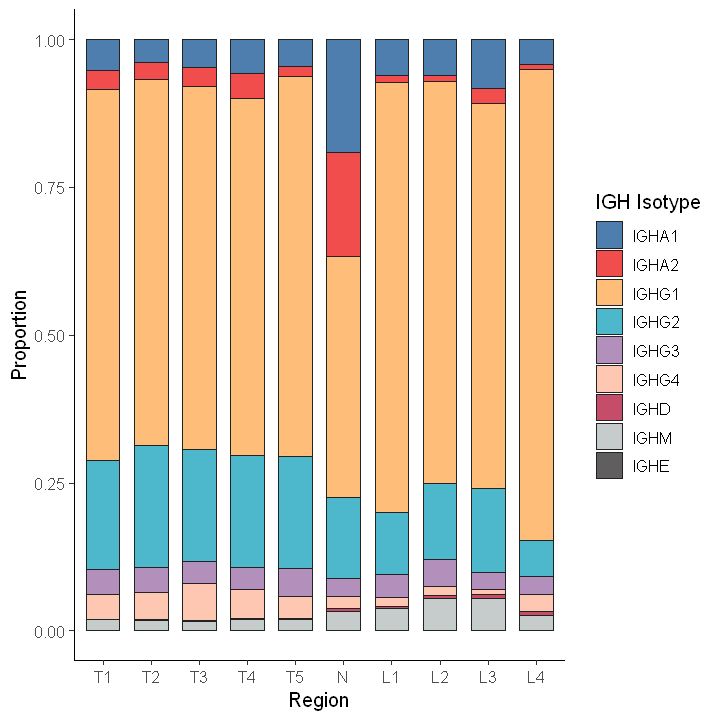

In [14]:
Cellratio<-prop.table(table(meta_multi_region_merged_diversity$type,meta_multi_region_merged_diversity$C),margin=1)
Cellratio <- as.data.frame(Cellratio)
Cellratio$Var1<-factor(Cellratio$Var1,levels=c("T1","T2","T3","T4","T5","N","L1","L2","L3","L4"))
Cellratio$Var2<-factor(Cellratio$Var2,levels=c("IGHA1","IGHA2","IGHG1","IGHG2","IGHG3","IGHG4","IGHD","IGHM","IGHE"))

g_IGH_propM<-ggplot(Cellratio)+
    geom_bar(aes(x=Var1,y=Freq,fill=Var2),stat="identity",width=0.7,size=0.5,colour="#222222")+
    theme_classic2()+
    labs(x='Region',y='Proportion')+
    scale_fill_manual(values=mypal)+
    guides(fill=guide_legend(title="IGH Isotype"))
    #theme(panel.border = element_rect(fill=NA,color="black",size=0.5,linetype="solid"))
    
#pdf("Fig1.IGH_prop_bar.pdf",4,4)
g_IGH_propM
dev.off()

## Fig1G

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 1446 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 1446 rows containing non-finite values (`stat_signif()`)."


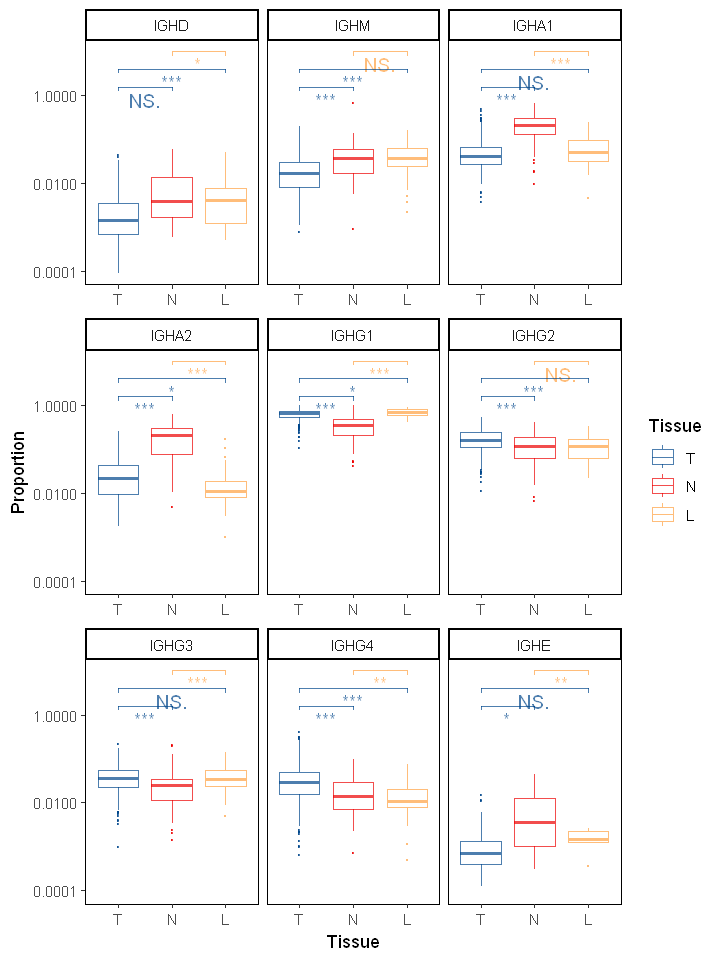

In [11]:
MR_IGH_data=meta_multi_region_merged_diversity
#MR_IGH_data$type=str_sub(MR_IGH_data$type,1,1)
Cellratio<-prop.table(table(MR_IGH_data$C,MR_IGH_data$`ID`),margin=2)
Cellratio<- as.data.frame(Cellratio)

#library(reshape2)
#Cellratio_long<-melt(Cellratio,value.name="Frequency")
colnames(Cellratio)<-c("C_Genes","ID","Proportion")

Cellratio$type<-str_sub(Cellratio$ID,8,8)

Cellratio$type<-factor(Cellratio$type, levels = c("T","N","L"))
Cellratio$C_Genes<-factor(Cellratio$C_Genes, levels = c("IGHD","IGHM","IGHA1","IGHA2","IGHG1","IGHG2","IGHG3","IGHG4","IGHE"))
colnames(Cellratio)[4]="Tissue"

gg<-ggplot(Cellratio,aes(x=Tissue,y=Proportion,col=Tissue))+
    geom_boxplot(outlier.size = .1)+
    geom_signif(comparisons = list(c("T", "N"),c("T","L"),c("L","N")),
              map_signif_level=T,
              textsize=4,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    theme(panel.border = element_rect(fill=NA,color="black",size=0.5,linetype="solid"))+
    #theme(axis.text.x=element_text(angle=90,hjust=1,vjust=.5))+
    #theme(axis.text=element_text(size=12))+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE),breaks=(c(0.0001,0.01,1)))+
        guides(fill=guide_legend(title="IGH Isotype"))+
    facet_wrap(.~C_Genes,scales="free_x")

options(repr.plot.width = 6, repr.plot.height = 8)
gg

#pdf("Fig1.MR_IGH_type_proportion_boxplot.pdf",6,6)
#gg
#dev.off()

In [13]:
write.csv(Cellratio,"Fig1G.csv",row.names=FALSE,quote=FALSE)

## FigBCD

## 3.3 compare diversity

In [14]:
dim(meta_multi_region_merged_diversity)
MR_diversity<-meta_multi_region_merged_diversity[!duplicated(meta_multi_region_merged_diversity$ID),]
MR_diversity$type<-str_sub(MR_diversity$type,1,1)
MR_diversity$type<-factor(MR_diversity$type, levels = c("T","N","L"))

[1] 596034     73

In [16]:
MR_diversity_selected<-MR_diversity[,c('type','s_richness','s_clonality','s_shannon')]
write.csv(MR_diversity_selected,"Fig1BCD.csv",row.names=FALSE,quote=FALSE)

In [16]:
library(cowplot)

g1<-ggplot(MR_diversity,aes(x=type,y=s_richness,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(panel.border = element_rect(fill=NA,color="black",size=0.5,linetype="solid"))+
    theme(axis.text=element_text(size=8))+
    theme(axis.title = element_text(size = 8))+
    labs(x="Tissue",y="IGH Richness")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))


g2<-ggplot(MR_diversity,aes(x=type,y=s_clonality,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(panel.border = element_rect(fill=NA,color="black",size=0.5,linetype="solid"))+
    theme(axis.text=element_text(size=8))+
    theme(axis.title = element_text(size = 8))+
    labs(x="Tissue",y="IGH Clonality")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))

g3<-ggplot(MR_diversity,aes(x=type,y=s_shannon,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(panel.border = element_rect(fill=NA,color="black",size=0.5,linetype="solid"))+
    theme(axis.text=element_text(size=8))+
    theme(axis.title = element_text(size = 8))+
    labs(x="Tissue",y="IGH Shannon")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))

options(repr.plot.width = 15, repr.plot.height = 5)
diversity_plot<-g1+g2+g3+plot_layout(nrow=1)

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


Warning message:
"Removed 1 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 1 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_signif()`)."


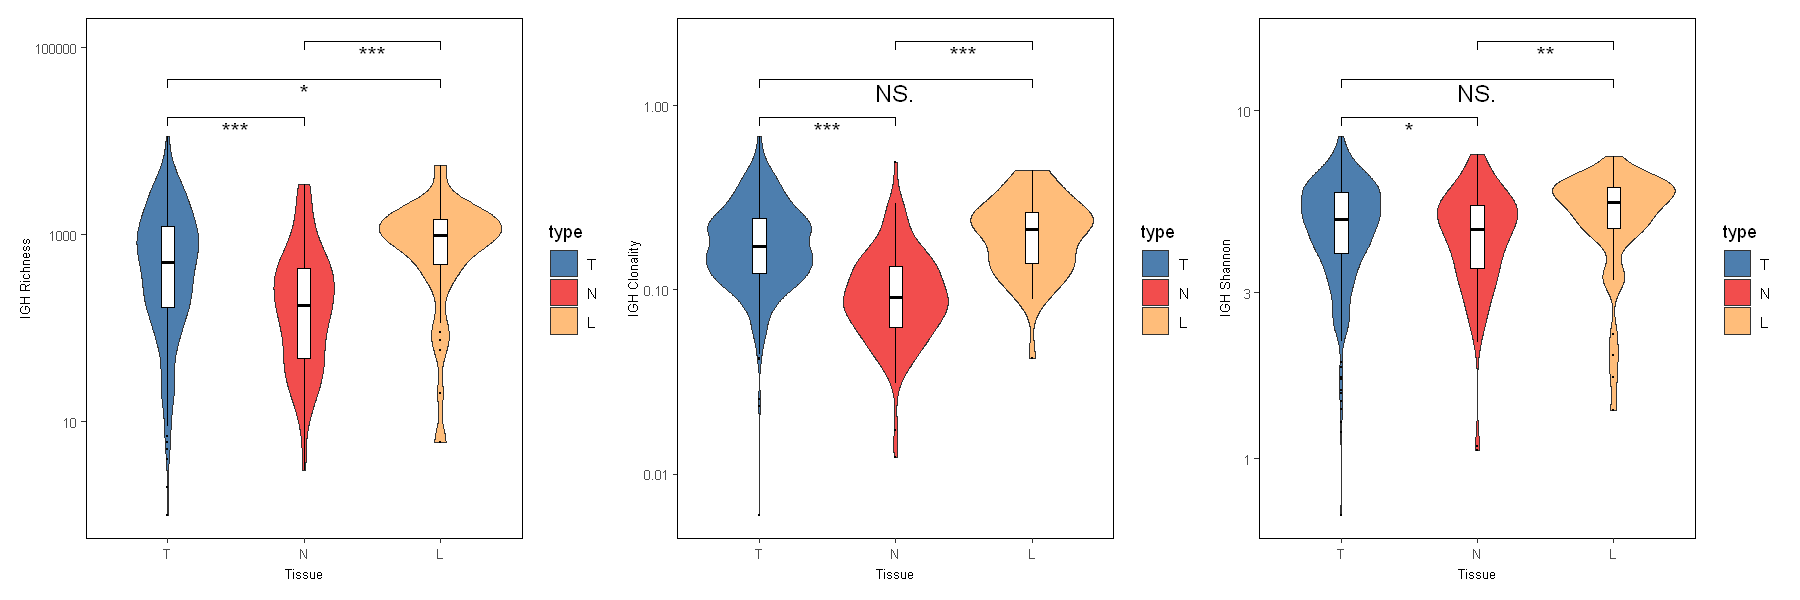

In [17]:
diversity_plot

In [26]:
pdf("Fig1.Diversity.plot.pdf",12,4)
diversity_plot
dev.off()

Warning message:
"Removed 1 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1 rows containing non-finite values (stat_signif)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 1 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1 rows containing non-finite values (stat_signif)."


png 
  2

In [18]:
MR_diversity_selected<-MR_diversity[,c('type','s_richness_IGHM','s_richness_IGHD','s_richness_IGHA1','s_richness_IGHA2',
                                    's_richness_IGHG1','s_richness_IGHG2','s_richness_IGHG3','s_richness_IGHG4','s_richness_IGHE')]
write.csv(MR_diversity_selected,"Fig1F.csv",row.names=FALSE,quote=FALSE)

In [18]:

g2<-ggplot(MR_diversity,aes(x=type,y=s_richness_IGHM,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(axis.text=element_text(size=14))+
    theme(axis.title = element_text(size = 16))+
    labs(x="Tissue",y="IGHM Richness")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))
    
g1<-ggplot(MR_diversity,aes(x=type,y=s_richness_IGHD,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(axis.text=element_text(size=14))+
    theme(axis.title = element_text(size = 16))+
    labs(x="Tissue",y="IGHD Richness")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))

g3<-ggplot(MR_diversity,aes(x=type,y=s_richness_IGHA1,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(axis.text=element_text(size=14))+
    theme(axis.title = element_text(size = 16))+
    labs(x="Tissue",y="IGHA1 Richness")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))

g4<-ggplot(MR_diversity,aes(x=type,y=s_richness_IGHA2,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(axis.text=element_text(size=14))+
    theme(axis.title = element_text(size = 16))+
    labs(x="Tissue",y="IGHA2 Richness")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))

g5<-ggplot(MR_diversity,aes(x=type,y=s_richness_IGHG1,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(axis.text=element_text(size=14))+
    theme(axis.title = element_text(size = 16))+
    labs(x="Tissue",y="IGHG1 Richness")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))

g6<-ggplot(MR_diversity,aes(x=type,y=s_richness_IGHG2,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(axis.text=element_text(size=14))+
    theme(axis.title = element_text(size = 16))+
    labs(x="Tissue",y="IGHG2 Richness")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))

g7<-ggplot(MR_diversity,aes(x=type,y=s_richness_IGHG3,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(axis.text=element_text(size=12))+
    theme(axis.title = element_text(size = 12))+
    labs(x="Tissue",y="IGHG3 Richness")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))

g8<-ggplot(MR_diversity,aes(x=type,y=s_richness_IGHG4,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(axis.text=element_text(size=12))+
    theme(axis.title = element_text(size = 12))+
    labs(x="Tissue",y="IGHG4 Richness")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))    

g9<-ggplot(MR_diversity,aes(x=type,y=s_richness_IGHE,fill=type))+geom_violin()+
    geom_boxplot(col="black",fill="white",width=.1,outlier.size = 0)+
    geom_signif(comparisons = list(c("T", "N"),c("T", "L"),c("L", "N")),
              map_signif_level=T,
              textsize=5,test=wilcox.test,step_increase=0.1,vjust=1.5,tip_length=0.02) +
    theme_classic()+
    #labs(x='CDR3 Length',y='Proportion')+
    scale_color_manual(values=mypal)+
    scale_fill_manual(values=mypal)+
    theme(axis.text=element_text(size=12))+
    theme(axis.title = element_text(size = 12))+
    labs(x="Tissue",y="IGHE Richness")+
    scale_y_log10(labels = function(x) format(x, scientific = FALSE))


Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 436 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 436 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 436 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 89 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 89 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 89 rows containing non-finite values (`stat_signif()`)."
W

png 
  2

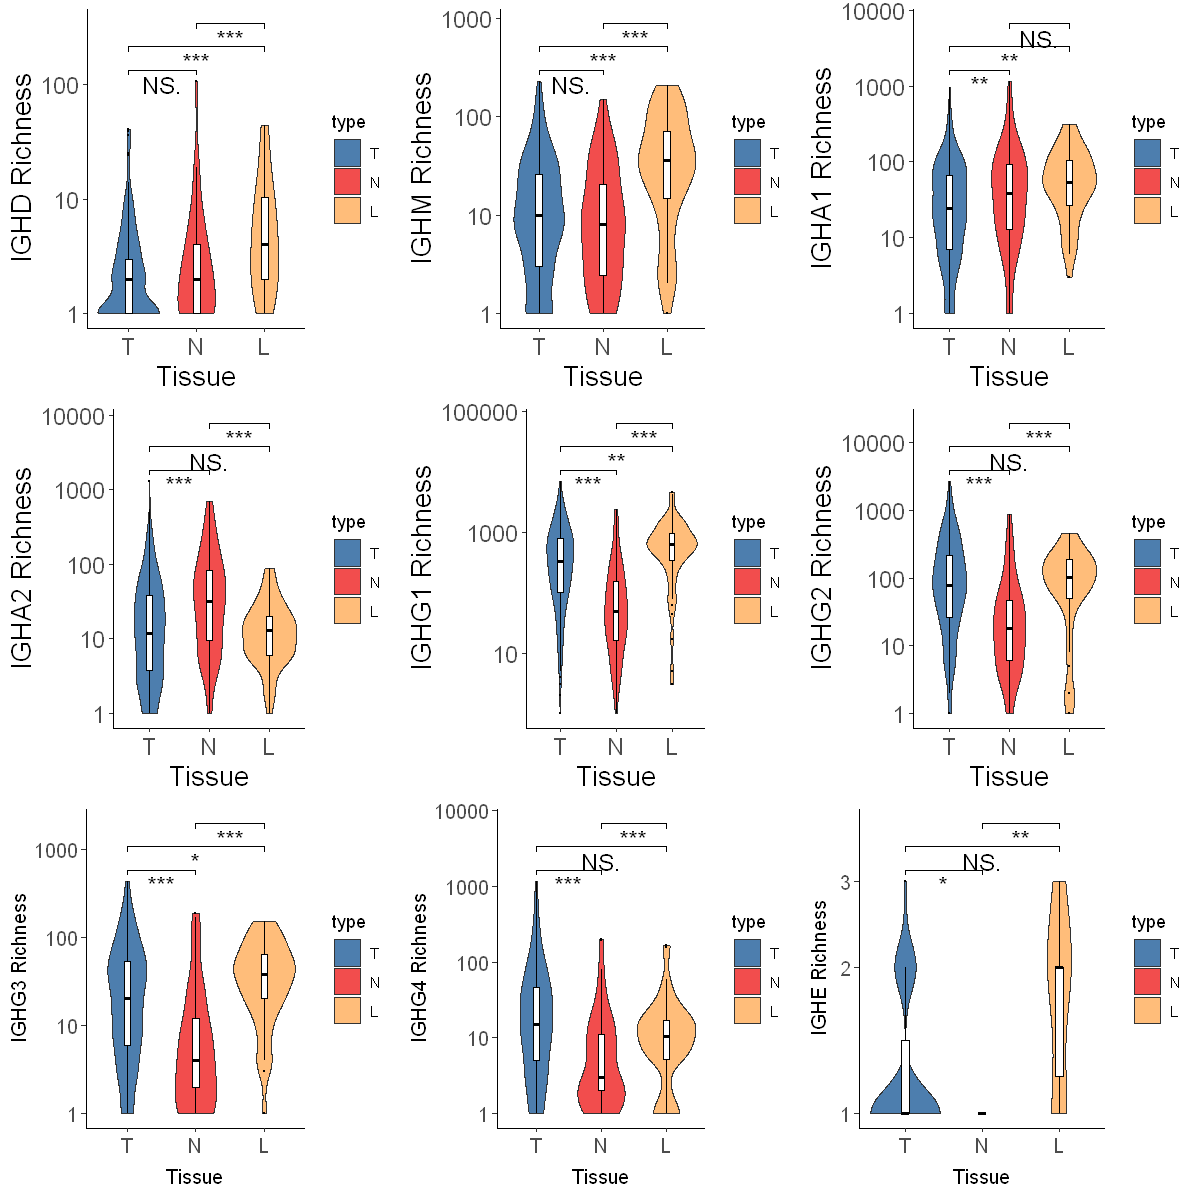

In [20]:
options(repr.plot.width = 10, repr.plot.height = 10)
isotype_richness<-g1+g2+g3+g4+g5+g6+g7+g8+g9+plot_layout(nrow = 3)
plot_grid(g1,g2,g3,g4,g5,g6,g7,g8,g9,nrow = 3,align=c("h"))

pdf("Fig1.isotype.richness.pdf",15,12)
plot_grid(g1,g2,g3,g4,g5,g6,g7,g8,g9,nrow = 3,align=c("h"))
dev.off()